In [22]:
import ctypes
import time

import matplotlib.pyplot as plt
import os
import mmap
import struct
import numpy as np
import subprocess

from dma_driver import *

In [23]:
def run_command(command):
    """Ejecuta un comando en la terminal y muestra la salida en tiempo real."""
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    for line in process.stdout:
        print(line, end="")  # Imprime la salida en tiempo real

    process.wait()  # Esperar a que termine el proceso
    if process.returncode != 0:
        print(f"\nError en el comando: {command}")
        print(process.stderr.read())

In [24]:
run_command("xmutil unloadapp")
run_command("xmutil loadapp ictp_dma")

remove from slot 0 returns: 0 (Ok)
ictp_dma: loaded to slot 0


In [25]:
f = open("/dev/mem", "r+b")
    
# Mapear la memoria del DMA
dma_sm = mmap.mmap(f.fileno(), DMA_MAP_SIZE, offset=DMA_SINE_ADDR)
dst_sm = mmap.mmap(f.fileno(), DST_MAP_SIZE, offset=DST_SINE_ADDR)


###################################################
t0 = time.perf_counter()

print("Resetting the DMA...")
write_dma(dma_sm, S2MM_CONTROL_REGISTER, RESET_DMA)
dma_s2mm_status(dma_sm)

print("Halting the DMA...")
write_dma(dma_sm, S2MM_CONTROL_REGISTER, HALT_DMA)
dma_s2mm_status(dma_sm)

print("Enabling all interrupts...")
write_dma(dma_sm, S2MM_CONTROL_REGISTER, ENABLE_ALL_IRQ)
dma_s2mm_status(dma_sm)

print("Writing the destination address...")
write_dma(dma_sm, S2MM_DST_ADDRESS_REGISTER, DST_SINE_ADDR)
dma_s2mm_status(dma_sm)

print("Running the S2MM channel...")
write_dma(dma_sm, S2MM_CONTROL_REGISTER, RUN_DMA)
dma_s2mm_status(dma_sm)

print("Writing S2MM transfer length of 8192 bytes...")
write_dma(dma_sm, S2MM_BUFF_LENGTH_REGISTER, DST_MAP_SIZE)
dma_s2mm_status(dma_sm)

print("Waiting for S2MM synchronization...")
dma_s2mm_sync(dma_sm)

print("Final DMA status:")
dma_s2mm_status(dma_sm)

t1 = time.perf_counter()
###################################################
print(f"Tiempo total DMA (Python mmap): {(t1 - t0)*1e3:.3f} ms")

Resetting the DMA...
Stream to memory-mapped status (0x00000001):
  Halted.

Halting the DMA...
Stream to memory-mapped status (0x00000001):
  Halted.

Enabling all interrupts...
Stream to memory-mapped status (0x00000001):
  Halted.

Writing the destination address...
Stream to memory-mapped status (0x00000001):
  Halted.

Running the S2MM channel...
Stream to memory-mapped status (0x00000000):

Writing S2MM transfer length of 8192 bytes...
Stream to memory-mapped status (0x00005011):
  Halted.
  IOC interrupt occurred.

Waiting for S2MM synchronization...
Final DMA status:
Stream to memory-mapped status (0x00005011):
  Halted.
  IOC interrupt occurred.

Tiempo total DMA (Python mmap): 22.706 ms


Tiempo total DMA (Python mmap): 50.313 ms


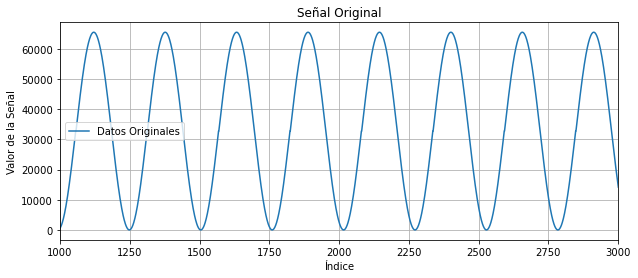

In [26]:
t0 = time.perf_counter()

data = get_mem_data(dst_sm, DST_MAP_SIZE)

t1 = time.perf_counter()
###################################################
print(f"Tiempo total DMA (Python mmap): {(t1 - t0)*1e3:.3f} ms")

plot_mem_data(data)

### Prueba de tiempo

adquisicion de datos desde DMA

Stream to memory-mapped status (0x00005011):
  Halted.
  IOC interrupt occurred.

Tiempo total DMA (Python mmap): 2.561 ms
Tiempo total DMA (Python mmap): 52.107 ms


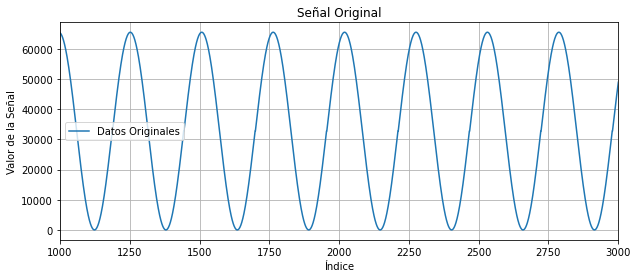

In [27]:
###################################################
t0 = time.perf_counter()

write_dma(dma_sm, S2MM_CONTROL_REGISTER, RESET_DMA)
write_dma(dma_sm, S2MM_CONTROL_REGISTER, HALT_DMA)
write_dma(dma_sm, S2MM_CONTROL_REGISTER, ENABLE_ALL_IRQ)
write_dma(dma_sm, S2MM_DST_ADDRESS_REGISTER, DST_SINE_ADDR)
write_dma(dma_sm, S2MM_CONTROL_REGISTER, RUN_DMA)
write_dma(dma_sm, S2MM_BUFF_LENGTH_REGISTER, DST_MAP_SIZE)
dma_s2mm_status(dma_sm)

t1 = time.perf_counter()
###################################################
print(f"Tiempo total DMA (Python mmap): {(t1 - t0)*1e3:.3f} ms")


t0 = time.perf_counter()

data = get_mem_data(dst_sm, DST_MAP_SIZE)

t1 = time.perf_counter()
###################################################
print(f"Tiempo total DMA (Python mmap): {(t1 - t0)*1e3:.3f} ms")

plot_mem_data(data)

Stream to memory-mapped status (0x00000000):

Run 01: DMA = 0.405 ms, Read = 50.199 ms
Stream to memory-mapped status (0x00000000):

Run 02: DMA = 0.239 ms, Read = 48.327 ms
Stream to memory-mapped status (0x00000000):

Run 03: DMA = 0.221 ms, Read = 48.075 ms
Stream to memory-mapped status (0x00000000):

Run 04: DMA = 0.220 ms, Read = 48.146 ms
Stream to memory-mapped status (0x00000000):

Run 05: DMA = 0.219 ms, Read = 48.106 ms
Stream to memory-mapped status (0x00000000):

Run 06: DMA = 0.224 ms, Read = 49.745 ms
Stream to memory-mapped status (0x00000000):

Run 07: DMA = 0.238 ms, Read = 48.680 ms
Stream to memory-mapped status (0x00000000):

Run 08: DMA = 0.221 ms, Read = 48.361 ms
Stream to memory-mapped status (0x00000000):

Run 09: DMA = 0.218 ms, Read = 48.825 ms
Stream to memory-mapped status (0x00000000):

Run 10: DMA = 0.230 ms, Read = 49.982 ms
Stream to memory-mapped status (0x00000000):

Run 11: DMA = 0.229 ms, Read = 49.422 ms
Stream to memory-mapped status (0x00000000)

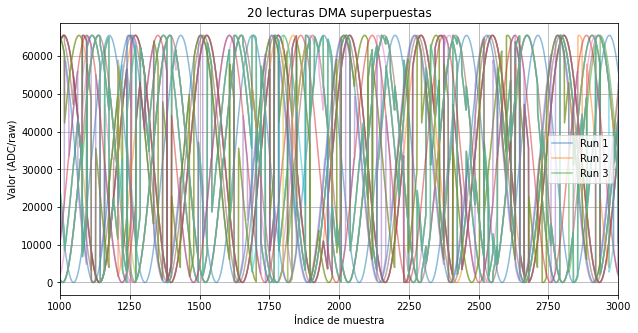

In [28]:
num_runs = 20
dma_times = []
read_times = []
all_data = []

for i in range(num_runs):
    # -------------------------
    # Medir tiempo DMA
    # -------------------------
    t0 = time.perf_counter()

    write_dma(dma_sm, S2MM_CONTROL_REGISTER, RESET_DMA)
    write_dma(dma_sm, S2MM_CONTROL_REGISTER, HALT_DMA)
    write_dma(dma_sm, S2MM_CONTROL_REGISTER, ENABLE_ALL_IRQ)
    write_dma(dma_sm, S2MM_DST_ADDRESS_REGISTER, DST_SINE_ADDR)
    write_dma(dma_sm, S2MM_CONTROL_REGISTER, RUN_DMA)
    write_dma(dma_sm, S2MM_BUFF_LENGTH_REGISTER, DST_MAP_SIZE)
    dma_s2mm_status(dma_sm)  # espera a que termine

    t1 = time.perf_counter()
    dma_times.append((t1 - t0) * 1e3)

    # -------------------------
    # Medir tiempo de lectura
    # -------------------------
    t0 = time.perf_counter()
    data = get_mem_data(dst_sm, DST_MAP_SIZE)
    t1 = time.perf_counter()
    read_times.append((t1 - t0) * 1e3)

    # Guardar para graficar
    all_data.append(data)

    print(f"Run {i+1:02d}: DMA = {dma_times[-1]:.3f} ms, Read = {read_times[-1]:.3f} ms")

# -------------------------
# Estadísticas
# -------------------------
print("\n=== Benchmark summary (20 runs) ===")
print(f"DMA avg:   {np.mean(dma_times):.3f} ms (± {np.std(dma_times):.3f})")
print(f"Read avg:  {np.mean(read_times):.3f} ms (± {np.std(read_times):.3f})")

# -------------------------
# Graficar todas las curvas
# -------------------------
plt.figure(figsize=(10,5))
x = np.arange(len(all_data[0]))

for i, d in enumerate(all_data):
    plt.plot(x, d, alpha=0.5, label=f"Run {i+1}" if i < 3 else None)  # solo etiqueta primeras 3

plt.title("20 lecturas DMA superpuestas")
plt.xlabel("Índice de muestra")
plt.ylabel("Valor (ADC/raw)")
plt.grid(True)
plt.xlim([1000, 3000])
plt.legend()
plt.show()